In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from pathlib import Path

from learn.dataset import TabularDataset
from learn.model import CiteAutoencoder
from learn.train import train_model, get_encodings

import umap
import plotly.express as px
import plotly.graph_objects as go

In [3]:
data_path = Path("./data/")
list(data_path.iterdir())

[PosixPath('data/metadata.csv.gz'),
 PosixPath('data/protein_scale.csv.gz'),
 PosixPath('data/rna_scale.csv.gz')]

In [4]:
rna = pd.read_csv(data_path/"rna_scale.csv.gz", index_col=0).T
rna = rna.reset_index(drop=True)
rna.head()

IGKC      HBA2       HBB      HBA1     IGHA1     IGLC2    JCHAIN  \
0 -0.428204  0.183748  0.406723 -0.488968  1.248214 -0.614123 -0.324617   
1 -1.047339 -0.601956 -0.985002 -0.488968 -0.552748 -0.614123 -0.324617   
2 -1.047339 -0.601956  1.534527 -0.488968 -0.552748 -0.614123 -0.324617   
3  0.080052  0.828744  0.614775  1.051572 -0.552748  0.713069 -0.324617   
4  0.953832 -0.601956  0.794895 -0.488968  1.413335 -0.614123 -0.324617   

        HBM     IGHG1      IGHM  ...      INSR    RAD23B    COMMD4     PPARA  \
0 -0.181656 -0.200979 -0.414643  ... -0.216175  2.892558 -0.237605 -0.122832   
1 -0.181656  4.964708 -0.414643  ... -0.216175 -0.342985 -0.237605 -0.122832   
2 -0.181656 -0.200979 -0.414643  ... -0.216175 -0.342985  6.509144 -0.122832   
3 -0.181656 -0.200979 -0.414643  ...  4.322459 -0.342985  4.264288 -0.122832   
4 -0.181656 -0.200979 -0.414643  ... -0.216175 -0.342985 -0.237605 -0.122832   

      PFDN6     PDSS1     BANF1      DDI2     DCAF6    HSPA5  
0 -0.329040 -0.130763 -0.506981  3.164261 -0.197585 -0.44033  
1 -0.329040 -0.130763 -0.506981 -0.171434 -0.197585 -0.44033  
2 -0.329040 -0.130763 -0.506981 -0.171434 -0.197585 -0.44033  
3 -0.329040 -0.130763 -0.506981 -0.171434 -0.197585 -0.44033  
4  3.360494 -0.130763 -0.506981 -0.171434 -0.197585 -0.44033  

[5 rows x 2000 columns]

In [5]:
pro = pd.read_csv(data_path/"protein_scale.csv.gz", index_col=0).T
pro = pro.reset_index(drop=True)
pro.head()

CD11a     CD11c     CD123  CD127-IL7Ra      CD14      CD16     CD161  \
0 -1.849174 -0.372667 -0.072177    -0.634849 -0.464785  0.207650 -0.005108   
1  0.343613 -1.012818 -0.474588     1.776928 -0.672261 -0.152689  5.036511   
2 -0.829742 -0.847536 -0.675120     0.705449 -0.654620 -0.427962 -0.443269   
3  0.157304 -0.601292 -0.558123     0.758353 -0.660516 -0.384782  0.052340   
4  1.606986  1.762460  0.264567    -0.918552  2.004037 -0.497364 -0.392328   

       CD19  CD197-CCR7      CD25  ...      CD38       CD4    CD45RA  \
0 -0.361779    0.691453  0.492961  ...  1.046025 -0.578292 -0.685804   
1 -0.352564   -1.541172 -0.942280  ... -0.665740  1.435716 -1.205478   
2 -0.478648   -0.552103 -1.208599  ...  0.010368  1.745735  0.426769   
3 -0.413611   -0.338678 -0.098834  ... -0.202340  1.596914 -1.300920   
4 -0.327233   -0.539660 -0.375834  ...  1.264582 -0.308044 -1.246741   

     CD45RO      CD56      CD57      CD69     CD79b      CD8a    HLA.DR  
0 -0.618250  0.486534  1.084345  0.114363 -0.279477 -0.474619  0.998738  
1  0.359657  2.607521 -0.612902 -1.146097  0.245467 -0.762164 -0.838409  
2 -1.072402 -0.223553  1.059687 -0.635409 -0.844739 -0.448139 -1.074838  
3  2.089684 -0.637078 -0.166773 -0.541819 -0.646660 -0.663541 -0.589663  
4  0.639829 -0.511057  0.300100  1.660178 -0.351614 -0.581021  0.766440  

[5 rows x 25 columns]

In [6]:
nfeatures_rna = rna.shape[1]
nfeatures_pro = pro.shape[1]

print(nfeatures_rna, nfeatures_pro)

2000 25


In [7]:
# concat rna and pro
citeseq = pd.concat([rna, pro], axis=1)
citeseq.head()

IGKC      HBA2       HBB      HBA1     IGHA1     IGLC2    JCHAIN  \
0 -0.428204  0.183748  0.406723 -0.488968  1.248214 -0.614123 -0.324617   
1 -1.047339 -0.601956 -0.985002 -0.488968 -0.552748 -0.614123 -0.324617   
2 -1.047339 -0.601956  1.534527 -0.488968 -0.552748 -0.614123 -0.324617   
3  0.080052  0.828744  0.614775  1.051572 -0.552748  0.713069 -0.324617   
4  0.953832 -0.601956  0.794895 -0.488968  1.413335 -0.614123 -0.324617   

        HBM     IGHG1      IGHM  ...      CD38       CD4    CD45RA    CD45RO  \
0 -0.181656 -0.200979 -0.414643  ...  1.046025 -0.578292 -0.685804 -0.618250   
1 -0.181656  4.964708 -0.414643  ... -0.665740  1.435716 -1.205478  0.359657   
2 -0.181656 -0.200979 -0.414643  ...  0.010368  1.745735  0.426769 -1.072402   
3 -0.181656 -0.200979 -0.414643  ... -0.202340  1.596914 -1.300920  2.089684   
4 -0.181656 -0.200979 -0.414643  ...  1.264582 -0.308044 -1.246741  0.639829   

       CD56      CD57      CD69     CD79b      CD8a    HLA.DR  
0  0.486534  1.084345  0.114363 -0.279477 -0.474619  0.998738  
1  2.607521 -0.612902 -1.146097  0.245467 -0.762164 -0.838409  
2 -0.223553  1.059687 -0.635409 -0.844739 -0.448139 -1.074838  
3 -0.637078 -0.166773 -0.541819 -0.646660 -0.663541 -0.589663  
4 -0.511057  0.300100  1.660178 -0.351614 -0.581021  0.766440  

[5 rows x 2025 columns]

In [8]:
train, valid = train_test_split(citeseq.to_numpy(dtype=np.float32), test_size=0.1, random_state=0)
train.shape, valid.shape

((27604, 2025), (3068, 2025))

In [9]:
train[0]

array([ 1.2470618 , -0.6019564 , -0.9850023 , ..., -0.13890247,
       -0.5083658 , -1.1323029 ], dtype=float32)

In [10]:
train_ds = TabularDataset(train)
valid_ds = TabularDataset(valid)

In [11]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=False)

In [12]:
x, y = next(iter(train_dl))
x.shape, y.shape

(torch.Size([64, 2025]), torch.Size([64, 2025]))

In [13]:
model = CiteAutoencoder(nfeatures_rna, nfeatures_pro, hidden_rna=85,
                        hidden_pro=15, z_dim=20)

In [14]:
model

CiteAutoencoder(
  (encoder): Encoder(
    (encoder_rna): LinBnDrop(
      (0): Linear(in_features=2000, out_features=85, bias=False)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(85, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.1, inplace=False)
    )
    (encoder_protein): LinBnDrop(
      (0): Linear(in_features=25, out_features=15, bias=False)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.1, inplace=False)
    )
    (encoder): LinBnDrop(
      (0): Linear(in_features=100, out_features=20, bias=False)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): LinBnDrop(
        (0): Linear(in_features=20, out_features=100, bias=False)
        (1): LeakyReLU(negative_slope=0

In [15]:
model(x).shape

torch.Size([64, 2025])

In [16]:
lr = 1e-2
epochs = 50
model, losses = train_model(model, train_dl, valid_dl, lr=lr, epochs=epochs)

 20%|██        | 10/50 [00:20<01:20,  2.00s/it]

Epoch 10: train loss 0.6304446831075649; valid loss 0.619880107810631


 40%|████      | 20/50 [00:40<00:59,  1.99s/it]

Epoch 20: train loss 0.6246232056320621; valid loss 0.6144598307479003


 60%|██████    | 30/50 [00:59<00:39,  1.96s/it]

Epoch 30: train loss 0.6191212090093698; valid loss 0.6098339345495579


 80%|████████  | 40/50 [01:19<00:19,  1.98s/it]

Epoch 40: train loss 0.6141003234164297; valid loss 0.6072525131034106


100%|██████████| 50/50 [01:39<00:00,  1.99s/it]

Epoch 50: train loss 0.6113825075143732; valid loss 0.6064278795790641


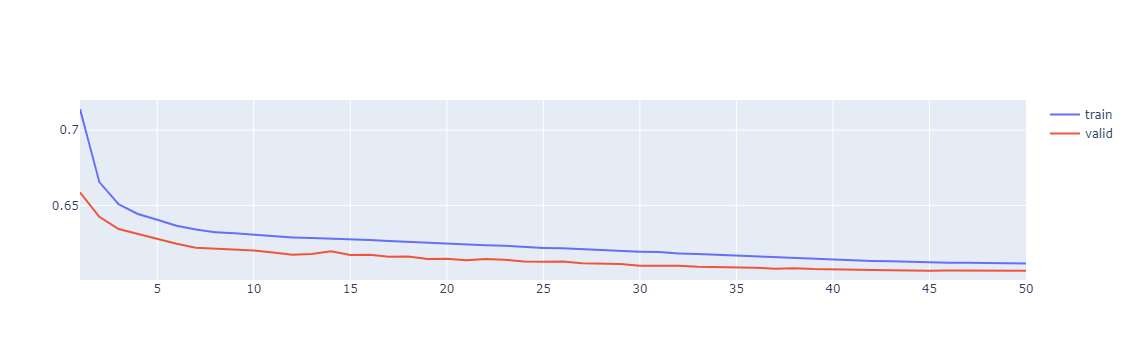

In [17]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(1, epochs+1, 1), y=losses['train'],
                         mode='lines',
                         name='train'))
fig.add_trace(go.Scatter(x=np.arange(1, epochs+1, 1), y=losses['valid'],
                         mode='lines',
                         name='valid'))
fig.show()

In [18]:
test_ds = TabularDataset(citeseq.to_numpy(dtype=np.float32))
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

encodings = get_encodings(model, test_dl)
encodings = encodings.cpu().numpy()
encodings.shape

(30672, 20)

In [19]:
# annotations
metadata = pd.read_csv(data_path/"metadata.csv.gz", index_col=0)
metadata.head()

orig.ident  nCount_RNA  nFeature_RNA  nCount_ADT  \
a_AAACCTGAGCTTATCG-1     bmcite        7546          2136        1350   
a_AAACCTGAGGTGGGTT-1     bmcite        1029           437        2970   
a_AAACCTGAGTACATGA-1     bmcite        1111           429        2474   
a_AAACCTGCAAACCTAC-1     bmcite        2741           851        4799   
a_AAACCTGCAAGGTGTG-1     bmcite        2099           843        5434   

                      nFeature_ADT       lane   donor       celltype.l1  \
a_AAACCTGAGCTTATCG-1            25  HumanHTO4  batch1  Progenitor cells   
a_AAACCTGAGGTGGGTT-1            25  HumanHTO1  batch1            T cell   
a_AAACCTGAGTACATGA-1            23  HumanHTO5  batch1            T cell   
a_AAACCTGCAAACCTAC-1            25  HumanHTO3  batch1            T cell   
a_AAACCTGCAAGGTGTG-1            25  HumanHTO2  batch1           Mono/DC   

                     celltype.l2  RNA.weight  ADT.weight  wsnn_res.2  \
a_AAACCTGAGCTTATCG-1    Prog_RBC    0.487299    0.512701          19   
a_AAACCTGAGGTGGGTT-1         gdT    0.245543    0.754457          10   
a_AAACCTGAGTACATGA-1   CD4 Naive    0.501680    0.498320           1   
a_AAACCTGCAAACCTAC-1  CD4 Memory    0.431308    0.568692           4   
a_AAACCTGCAAGGTGTG-1   CD14 Mono    0.572097    0.427903           2   

                      seurat_clusters  
a_AAACCTGAGCTTATCG-1               19  
a_AAACCTGAGGTGGGTT-1               10  
a_AAACCTGAGTACATGA-1                1  
a_AAACCTGCAAACCTAC-1                4  
a_AAACCTGCAAGGTGTG-1                2

In [25]:
# separate CD4 and CD8 in l1
metadata["celltype.l1.5"] = metadata["celltype.l1"].values
metadata.loc[metadata["celltype.l2"].str.startswith("CD4"), "celltype.l1.5"] = "CD4 T"
metadata.loc[metadata["celltype.l2"].str.startswith("CD8"), "celltype.l1.5"] = "CD8 T"
metadata.loc[metadata["celltype.l2"]=="Treg", "celltype.l1.5"] = "CD4 T"
metadata.loc[metadata["celltype.l2"]=="MAIT", "celltype.l1.5"] = "MAIT"
metadata.loc[metadata["celltype.l2"]=="gdT", "celltype.l1.5"] = "gdT"

In [26]:
embedding = umap.UMAP(random_state=0).fit_transform(encodings)

In [27]:
plot_df = metadata.copy()
plot_df["UMAP1"] = embedding[:, 0]
plot_df["UMAP2"] = embedding[:, 1]

In [28]:
fig = px.scatter(plot_df, x="UMAP1", y="UMAP2", color="celltype.l1.5")
fig.update_traces(marker=dict(size=4))
fig.show()